# Simplify Polygons

Since the volume of data is large, but spatially these data are coarse, there is no need to use shapes which have a high-spatial resolution. In fact that would be a bad idea, as that will slow down the processing time needlessly. 

So, what we will do, is generate a set of simplified geometries to work from in the following process:

1. Read a GADAM28 shapefile (global and Admin 1 level)
2. Extract the geometries, and simplify them to a degree that makes sense for the project.
3. Extract columns of data which are relevant to the project (e.g. Country name, iso. etc)
4. Create a new geopandas dataframe with these data
5. Write out these data to a shapefile
6. Use the new, minified data, as the shapes for our zonal analysis project.

Testing shows using the simplified shapes (with topology preserved) results in a 400% speedup (process a file in 30 seconds rather than 2 mins).

Now we need to work out how to deal with areas that return no values... (My imediate feeling is that if we need a fast turnaround on this project then we could simply buffer the smallest geometries and process like the others: this would still likely achieve a good result for the project. Experiment with this...)

In [34]:
import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
s = gpd.read_file('./data/gadm28_adm1/gadm28_adm1.shp')

In [3]:
s = s.to_crs(epsg='4326')

In [17]:
tmp_geoms = s.geometry.simplify(0.2, preserve_topology=True)  # Gives all little areas
#tmp_geoms = s.geometry.simplify(0.2, preserve_topology=False)  # removes all little areas (no point calculating)

In [18]:
new_data = []
for row_index in s.index:
    new_data.append([s['iso'][row_index],
                     s['name_0'][row_index],
                     s['id_1'][row_index],
                     s['name_1'][row_index],
                     s['type_1'][row_index],
                    ])

In [19]:
smaller_df = gpd.GeoDataFrame(pd.DataFrame(new_data,
                                        columns=['iso','name_0','id_1','name_1','type_1'])
                           , geometry=tmp_geoms)


In [28]:
#null_geom_mask = smaller_df.geometry.area != 0.0

In [32]:
#len(s) - len(smaller_df[null_geom_mask])

902

In simplifying the geometries and not preserving the smallest areas we loose ~902 admin1 areas out of 3,609.
These would have been too calculate anything with anyway.

Not sure what they should show on the front end currently. Either a greyed out area, or an association to the nearest polygon? Ideally they should be associated with the cell they coresspond to.

They would have no values for std, mean, min, max etc if they only occupy one gridcell. 

3609

In [ ]:
smaller_df.to_file("./data/gadm28_adm1_simplified/gadm28_adm1_simplified.shp", driver='ESRI Shapefile')

In [33]:
#smaller_df[null_geom_mask].to_file("./data/gadm28_adm1_simplified_topolost/gadm28_adm1_simplified_topolost.shp", driver='ESRI Shapefile')

In [16]:
smaller_df

,iso,name_0,id_1,name_1,type_1,geometry
0,MEX,Mexico,9,Ciudad de México,Distrito Federal,POLYGON ((-98.86537933349609 19.07119178771973...
1,HTI,Haiti,3,L'Artibonite,Département,(POLYGON ((-72.73760986328119 19.3176879882813...
2,HND,Honduras,1,Atlántida,Departamento,(POLYGON ((-86.77486419677734 15.8001394271851...
3,HND,Honduras,3,Colón,Departamento,(POLYGON ((-85.68819427490229 15.9501380920411...
4,GUY,Guyana,9,Upper Demerara-Berbice,Region,(POLYGON ((-58.58569335937499 6.33930492401128...
5,HND,Honduras,9,Gracias a Dios,Departamento,(POLYGON ((-84.92382812499994 14.7528009414673...
6,HND,Honduras,15,Olancho,Departamento,"POLYGON ((-84.99401855468744 15.0612087249757,..."
7,HND,Honduras,17,Valle,Departamento,(POLYGON ((-87.64097595214842 13.2987508773804...
8,PRY,Paraguay,11,Concepción,Departamento,POLYGON ((-56.81581115722651 -22.2892055511474...
9,PRY,Paraguay,14,Itapúa,Departamento,POLYGON ((-55.3094596862793 -26.10110855102533...


##  Same thing again, except this time for ADMIN0

Create simplified AMIN0 Shapes

Get ISO3 (not ISO2 values).

In [56]:
from iso3166 import countries

In [35]:
s = gpd.read_file('./data/minified_gadm28_countries/gadm28_countries.shp')
s = s.to_crs(epsg='4326')

In [54]:
s.head()

,geometry,iso2,name_engli,unregion2
0,(POLYGON ((7.576389789581356 57.98847198486345...,NO,Norway,Europe
1,POLYGON ((-171.786392211914 -9.147776603698617...,TK,Tokelau,Oceania
2,(POLYGON ((99.31054687500011 6.487649917602539...,TH,Thailand,Asia
3,(POLYGON ((-60.64263916015619 8.68402767181390...,VE,Venezuela,Americas
4,"(POLYGON ((6.095695018768311 4.35680580139183,...",NG,Nigeria,Africa


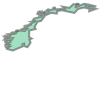

In [83]:
s.geometry[0].simplify(0.4, preserve_topology=False)

In [60]:
countries.get('NO').alpha3  # convert to 3-character ISO like so

'NOR'

In [65]:
countries.get('NO').name

'Norway'

In [61]:
# 'name_0', 'iso'  - name_0 should be name_engli and iso should be 3-character iso code

In [62]:
tmp_geoms = s.geometry.simplify(0.4, preserve_topology=True)  # Gives all little areas

 slight wrinkle, it appears South Sudan (SSD) is missing from the final file for some reason...
 
 Looks like not every country has an ISO code attached in the original data :(
 Will need to try and scrape it using the `countries` function

In [86]:
countries.get('SSD')

Country(name='South Sudan', alpha2='SS', alpha3='SSD', numeric='728', apolitical_name='South Sudan')

In [110]:
known_errors = {'Sint Maarten': 'SXM',
                'Saint-Barthélemy':'BL',
                'Curaçao': 'CUW',
                'Bonaire, Saint Eustatius and Saba':'BES',
                'South Sudan': 'SSD'}

In [115]:
a3_codes = []

for i in s.index:
    sname = s['name_engli'][i]
    siso2 = s['iso2'][i]
    try:
        a3 = countries.get(siso2).alpha3
    except:
        error_iso = known_errors[sname]
        a3 = countries.get(error_iso).alpha3
    a3_codes.append(a3)
    #print(i, sname, siso2, a3 )
    
# Hillariously, this also means I shouldnt use the names - as they are clearly crappy...
# Now I need to do the same thing, calling the names from the good iso codes
# This time it is a bit easier though!

good_names = [countries.get(code).name for code in a3_codes]

In [123]:
len(x),len(tmp_geoms)

(240, 240)

In [122]:
x = gpd.GeoDataFrame(pd.DataFrame([pair for pair in zip(a3_codes, good_names)], columns=['iso','name_0']),
                    geometry=tmp_geoms)
x.head()

,iso,name_0,geometry
0,NOR,Norway,(POLYGON ((7.576389789581356 57.98847198486345...
1,TKL,Tokelau,POLYGON ((-171.786392211914 -9.147776603698617...
2,THA,Thailand,(POLYGON ((99.31054687500011 6.487649917602539...
3,VEN,"Venezuela, Bolivarian Republic of",(POLYGON ((-60.64263916015619 8.68402767181390...
4,NGA,Nigeria,"(POLYGON ((6.095695018768311 4.35680580139183,..."


In [ ]:
len(tmp_geoms)

In [125]:
x.to_file("./data/gadm28_adm0_simplified/gadm28_adm0_simplified.shp", driver='ESRI Shapefile')